In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import os
import sqlalchemy
from sqlalchemy import create_engine
import pipeline_plan_functions.utils.db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
import alloc_functions.daily as adf
import alloc_functions.cleanup as cleaner
import alloc_functions.mixed as mixed
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from pulp import *
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']

In [30]:
TIME_INT_IS = dt.timedelta(minutes=30)
N = int(dt.timedelta(days=1)/TIME_INT_IS)
POTENTIAL_TPS_IS = [i*TIME_INT_IS for i in range(N)]
TP_FRACT_IS = TIME_INT_IS/dt.timedelta(hours=1)
XMPG = 1
def find_allocation(idx, cnx):
    try:
        sql_query = f"""SELECT * FROM t_allocation WHERE allocation_id={idx} LIMIT 1"""
        current_allocation = pd.read_sql_query(sql_query, cnx).iloc[0].to_dict()
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error while fetching current allocation")
        raise(error)
    return current_allocation
def find_runs(runs, cnx):
    try:
        sql_query = f"""SELECT * FROM t_run_allocation WHERE run_id IN {runs}"""
        run_table = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error fetching run data")
        raise(error)
    return run_table
def load_charging_profile(scen, cnx):
    try:
        sql_query = f"""SELECT * FROM t_charge_demand WHERE scenario_id={scen}"""
        demand = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error getting charge profiles")
        raise(error)
    return demand
range_wltp = {
    5: 138,
    11: 185,
    33: 166
}
payload = {
    5: 765,
    11: 860,
    33: 1002
}
colors = {
    5: fps_colours[4],
    11: fps_colours[3],
    33: fps_colours[5]
}
name = {
    5: "Fiat e-Ducato",
    11: "Maxus eDeliver9",
    33: "Ford e-Transit"
}
vehicles = [5, 33, 11]

In [22]:
cnx = dbh.create_alch_engine()
alloc = find_allocation(117, cnx)
# title = "Historic Paragon"
title = 'ePoD Average'
# title = 'ePoD Peak'
routes = cleaner.get_allocated_routes(alloc['allocation_id'], cnx)
routes = cleaner.get_daily_route_data(routes, alloc, cnx).sort_index()
routes['category'] = 'x'
grouped = mixed.group_routes(routes)
turn = 5
charging_rate = 50*0.9
for idx in grouped.index:
    masklist = []
    dutyR = routes[(routes['date'] == idx[0])
                        & (routes['allocated_vehicle_id'] == idx[1])].index
    # Calculate IS shifts
    for r in dutyR:
        masklist.append(mixed.tp_journeys(routes.loc[r], turn))
    masklist.append(np.array(POTENTIAL_TPS_IS)
                        > (grouped.loc[idx, 'departure_time']-grouped.loc[idx, 'route_date']))
    masklist.append(np.array(POTENTIAL_TPS_IS)
                        < (grouped.loc[idx, 'arrival_time']-grouped.loc[idx, 'route_date']))
    n = len(masklist)
    tps = np.sum(np.vstack(masklist).sum(axis=0) == n)
    grouped.loc[idx, 'TPs'] = tps
average_kwh_mile = 0.49 / XMPG
grouped['extra_mileage'] = grouped['TPs']*TP_FRACT_IS*charging_rate/average_kwh_mile
grouped['reduced_mileage'] = (grouped['distance_miles']-grouped['extra_mileage']).clip(
    lower=grouped['IndMileage']*0.8)

for i in range(len(vehicles)):
    grouped[f'unfeasible_noIS_{i}'] = grouped['distance_miles'] >= range_wltp[vehicles[i]] * XMPG
    grouped[f'unfeasible_is_{i}'] = grouped['reduced_mileage'] >= range_wltp[vehicles[i]] * XMPG

nduties = len(grouped)
grouped.groupby('date').agg({
    'unfeasible_noIS_0': 'sum',
    'unfeasible_is_0': 'sum',
    'unfeasible_noIS_1': 'sum',
    'unfeasible_is_1': 'sum',
    'unfeasible_noIS_2': 'sum',
    'unfeasible_is_2': 'sum'
}).sum()*100/nduties

unfeasible_noIS_0    81.280788
unfeasible_is_0      18.719212
unfeasible_noIS_1    70.443350
unfeasible_is_1       5.418719
unfeasible_noIS_2    59.605911
unfeasible_is_2       2.463054
dtype: float64

### Histos

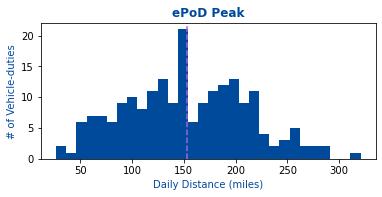

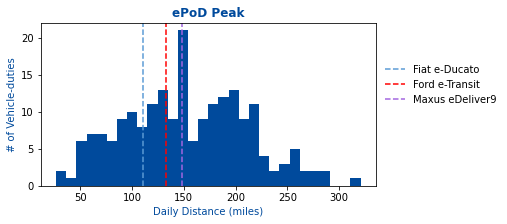

In [158]:
# All histos

fig, ax = plt.subplots(
    1, figsize=(6, 2.5), gridspec_kw={'hspace': 0.5})

ax.set_title(
    title,
    color=fps_colours[0], fontweight='bold')
ax.hist(
    grouped['distance_miles'],
    bins=30,
    color=[fps_colours[0]])

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_xlabel('Daily Distance (miles)', color=fps_colours[0])
ax.axvline(x=grouped['distance_miles'].mean(),
           label='Mean', ls='--', color=colors[v])


fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/combined_duties_alloc{alloc['allocation_id']}.png",
    bbox_inches="tight", dpi=300)

# EV feasibility
fig, ax = plt.subplots(
    1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    title,
    color=fps_colours[0], fontweight='bold')
ax.hist(
    grouped['distance_miles'],
    bins=30,
    color=[fps_colours[0]])

for v in vehicles:
    ax.axvline(x=range_wltp[v]*XMPG, label=name[v], ls='--', color=colors[v])

ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_xlabel('Daily Distance (miles)', color=fps_colours[0])


fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/feasibility{alloc['allocation_id']}.png",
    bbox_inches="tight", dpi=300)

### Charging Requirements basic allocation

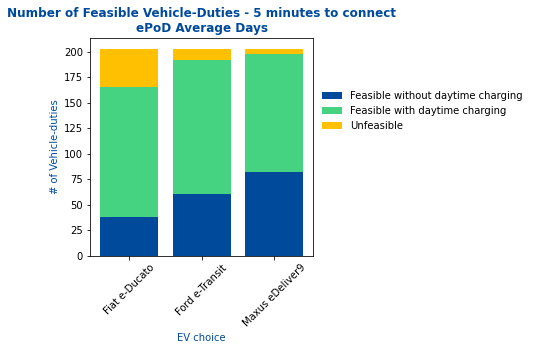

In [23]:
count_array = np.full((3,3), 0)
for i in range(len(vehicles)):
    # Number feasible without IS
    count_array[0][i] = (grouped['distance_miles'] < range_wltp[vehicles[i]] * XMPG).sum()
    # Number feasible only with IS
    count_array[1][i] = ((grouped['distance_miles'] >= range_wltp[vehicles[i]] * XMPG)
                         & (grouped['reduced_mileage'] < range_wltp[vehicles[i]] * XMPG)).sum()
    # NUmber unfeasible
    count_array[2][i] = ((grouped['reduced_mileage'] >= range_wltp[vehicles[i]] * XMPG)).sum()
count_array

fig, ax = plt.subplots(1, figsize=(4, 4))
xlabels = [name[v] for v in vehicles]
ax.bar(x = xlabels,
    height=count_array[0],
    color=[fps_colours[0]], label='Feasible without daytime charging')
ax.bar(x = xlabels,
    height=count_array[1], bottom=count_array[0],
    color=[fps_colours[1]], label='Feasible with daytime charging')
ax.bar(x = xlabels,
    height=count_array[2], bottom=count_array[1]+count_array[0],
    color=[fps_colours[2]], label='Unfeasible')
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_xlabel('EV choice', color=fps_colours[0])
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_title(
    f"Number of Feasible Vehicle-Duties - {turn} minutes to connect\n"
    f"{title} Days",
    color=fps_colours[0], fontweight='bold')
fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/feasibility_alloc{alloc['allocation_id']}_{turn}minutes.png",
    bbox_inches="tight", dpi=300)

### Charging Requirements Extra Vehicles

In [120]:
# Number feasible without IS
feasible_withoutis = (grouped['distance_miles'] < range_wltp[alloc['vehicle2']] * XMPG).sum()
# Number feasible only with IS
feasible_withis = (grouped['distance_miles'] >= range_wltp[alloc['vehicle2']] * XMPG).sum()
print(f"""Allocation {alloc['allocation_id']} with vehicle {name[alloc['vehicle2']]}
      without IS: {feasible_withoutis}, with IS: {feasible_withis}""")

Allocation 124 with vehicle Ford e-Transit
      without IS: 105, with IS: 95


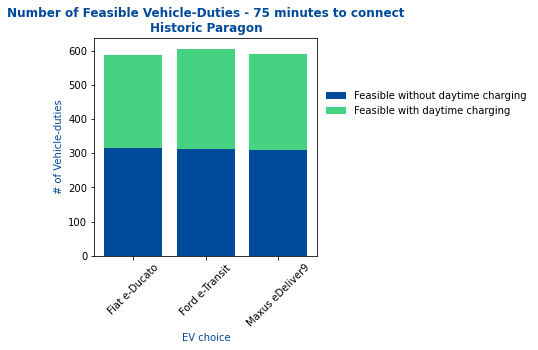

In [123]:
# EV feasibility

#Historic Paragon
count_array = np.array([[315, 314, 311], [274, 294, 281]])
# count_array = np.array([[81, 81, 91], [132, 123, 110]])  # avg
# count_array = np.array([[86, 105, 118], [105, 95, 79]])  # peak


fig, ax = plt.subplots(1, figsize=(4, 4))
xlabels = [name[v] for v in vehicles]
ax.bar(x = xlabels,
    height=count_array[0],
    color=[fps_colours[0]], label='Feasible without daytime charging')
ax.bar(x = xlabels,
    height=count_array[1], bottom=count_array[0],
    color=[fps_colours[1]], label='Feasible with daytime charging')
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_xlabel('EV choice', color=fps_colours[0])
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_title(
    f"Number of Feasible Vehicle-Duties - {turn} minutes to connect\n"
    f"{title}",
    color=fps_colours[0], fontweight='bold')
ax.tick_params(axis='x', labelrotation=45)
fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/feasibility_ev_{title}.png",
    bbox_inches="tight", dpi=300)

### Charging Profiles

datetime
2021-11-14 23:30:00    513.648498
2021-11-15 18:00:00    517.177047
2021-11-16 17:30:00    518.411511
2021-11-14 14:00:00    526.831432
2021-11-20 22:30:00    536.582462
2021-11-15 23:30:00    539.338949
2021-11-15 22:30:00    548.166918
2021-11-17 18:00:00    566.980598
2021-11-17 17:30:00    579.521076
2021-11-20 17:30:00    580.411517
2021-11-15 23:00:00    606.078835
2021-11-16 23:30:00    613.280450
2021-11-19 23:30:00    620.668033
2021-11-17 23:30:00    630.212670
2021-11-20 23:00:00    653.425704
2021-11-19 23:00:00    657.520828
2021-11-16 22:30:00    692.432987
2021-11-17 22:30:00    710.970916
2021-11-17 23:00:00    795.367140
2021-11-16 23:00:00    878.090487
Name: bau, dtype: float64
Mean: 118.42310677321454
MWh Consumed: 1037.38641533336


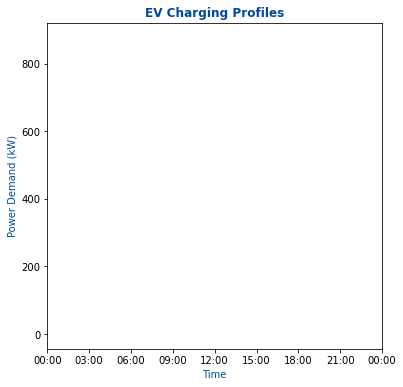

In [181]:
scenario = 71
profiles_bau = load_charging_profile(scenario, cnx)
charge_profiles = profiles_bau.groupby('datetime').sum()['power_demand_kw'].sort_index().rename('bau')
print(charge_profiles.sort_values().tail(20))
print('Mean:', charge_profiles.mean())
days = len(charge_profiles)/48
print('MWh Consumed:', (charge_profiles.sum()/2)*(365/days)/1000)

# EV charging
date = dt.datetime(2021, 10, 20)
fig, ax = plt.subplots(
    1, figsize=(6, 6), gridspec_kw={'hspace': 0.5})

ax.set_title(
    "EV Charging Profiles",
    color=fps_colours[0], fontweight='bold')
ax.plot(
    charge_profiles.index,
    charge_profiles,
    color=fps_colours[0], label='Charge on Arrival'
    )

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('Power Demand (kW)', color=fps_colours[0])
ax.set_xlabel('Time', color=fps_colours[0])
ax.set_xlim(left=date, right=date+dt.timedelta(days=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/demand{scenario}.png",
    bbox_inches="tight", dpi=300)

### Repeat runs

In [48]:
runs = tuple(np.arange(41, 49))
new_start_run = 97
run_table = find_runs(runs, cnx)
run_table['allocation_version'] = 'argos3'
run_table['vehicles'] = '[[33], []]'
run_table['chargers'] = '[11, 50]'
run_table['xmpg_change'] = -30
run_id_diff = run_table['run_id'] - run_table['run_id'].min()
run_table['run_id'] = new_start_run + run_id_diff
dbh.upload_table(run_table, 't_run_allocation')
run_table

2022-05-04 20:32:11|DEBUG|db_handler.py(62)|upload_table|Uploaded to t_run_allocation


,run_id,client_id,allocation_app,allocation_version,sites,start_date,end_date,vehicles,xmpg_change,chargers,route_table,cap_vehicles,mixed_fleet,source,num_v
0,97,2,allocate.py,argos3,[33],2021-10-17,2021-11-07,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],0,None
1,98,2,allocate.py,argos3,[33],2021-11-13,2021-11-21,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],101,None
2,99,2,allocate.py,argos3,[33],2021-09-19,2021-09-27,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],101,None
3,100,2,allocate.py,argos3,[281],2021-09-11,2021-09-12,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],201,None
4,101,2,allocate.py,argos3,[282],2021-09-11,2021-09-12,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],201,None
5,102,2,allocate.py,argos3,[278],2021-09-06,2021-09-07,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],201,None
6,103,2,allocate.py,argos3,[279],2021-09-10,2021-09-11,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],201,None
7,104,2,allocate.py,argos3,[280],2021-09-10,2021-09-11,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],201,None


### Shift starts

Text(0.5, 0, 'Time (hours)')

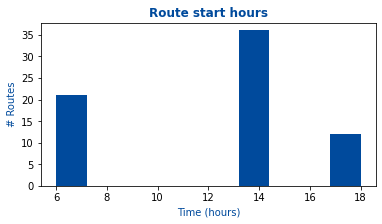

In [35]:
cnx = dbh.create_alch_engine()
site = 282
query = f"SELECT * FROM t_route_master WHERE site_id_start={site}"
routes = pd.read_sql_query(query, cnx)
hour_starts = (pd.to_datetime(routes['departure_time'])-pd.to_datetime(routes['departure_time'].dt.date)) / np.timedelta64(1, 'h')
fig, ax = plt.subplots(
    1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    'Route start hours',
    color=fps_colours[0], fontweight='bold')
ax.hist(
    hour_starts,
    # bins=30,
    color=[fps_colours[0]])

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# Routes', color=fps_colours[0])
ax.set_xlabel('Time (hours)', color=fps_colours[0])

### Upload EPOD-derived routes

In [6]:

path = 'sample/full_routes_epod_bristol_peak_avg.csv'
def load_sample_epod(path):
    try:
        connection, cur = dbh.database_connection('test')
        cols = ['route_id', 'departure_time', 'arrival_time',
                'distance_mileage', 'number_order']
        synth_routes = pd.read_csv(path, index_col=None, usecols=cols)
        synth_routes.rename(columns={
            'distance_mileage': 'distance_miles',
            'route_id': 'client_route_id'},
                            inplace=True)
        synth_routes['site_id_start'] = 33
        synth_routes['site_id_end'] = 33
        synth_routes['source'] = 101
        synth_routes['client_id'] = 2
        for c in ['departure_time', 'arrival_time']:
            synth_routes[c] = pd.to_datetime(synth_routes[c])
        query_str = ('SELECT route_id FROM t_route_master ORDER BY route_id DESC LIMIT 1')
        query_2 = ('SELECT route_id FROM t_telematics ORDER BY route_id DESC LIMIT 1')
        logger.info('reading formatted routing data from t_routing table')
        route_id = 1
        cur.execute(query_str)
        connection.commit()
        route_id_routes = cur.fetchall()[0][0]
        cur.execute(query_2)
        connection.commit()
        route_id_tel = cur.fetchall()[0][0]
        route_id = max(route_id_routes, route_id_tel) + 1
        synth_routes['route_id'] = route_id + np.arange(len(synth_routes))
    except Exception as err:
        raise err
    finally:
        cur.close()
        connection.close()
    return synth_routes

# synth_routes = load_sample_epod(path)
dbh.upload_table(synth_routes.drop(columns=['client_route_id']), 't_route_master')
synth_routes.to_csv('sample/epod_routes_formatted.csv')

2022-04-27 08:52:03|DEBUG|db_handler.py(62)|upload_table|Uploaded to t_route_master


In [10]:
synth_routes['date'] = synth_routes['departure_time'].dt.date
synth_routes

,client_route_id,departure_time,arrival_time,distance_miles,number_order,site_id_start,site_id_end,source,client_id,route_id,date
0,6062106,2021-09-19 14:47:03.000001200,2021-09-19 16:12:20.999998800,61.132343,1,33,33,101,2,164281,2021-09-19
1,6062108,2021-09-19 13:45:11.999999600,2021-09-19 14:43:20.000000000,47.826304,1,33,33,101,2,164282,2021-09-19
2,6062110,2021-09-19 14:43:53.000001200,2021-09-19 16:13:35.999998400,68.840450,2,33,33,101,2,164283,2021-09-19
3,6062114,2021-09-19 08:41:50.999998400,2021-09-19 12:33:33.000001200,106.329006,6,33,33,101,2,164284,2021-09-19
4,6062118,2021-09-19 09:02:17.000000800,2021-09-19 12:45:22.999998800,82.223539,7,33,33,101,2,164285,2021-09-19
...,...,...,...,...,...,...,...,...,...,...,...
964,6315062,2021-11-20 19:03:49.999999200,2021-11-20 21:43:37.999999600,26.759342,10,33,33,101,2,165245,2021-11-20
965,6315064,2021-11-20 19:09:05.000000000,2021-11-20 21:37:22.999999600,33.114725,13,33,33,101,2,165246,2021-11-20
966,6315066,2021-11-20 19:03:19.000001200,2021-11-20 21:19:09.999998400,27.514308,14,33,33,101,2,165247,2021-11-20
967,6315068,2021-11-20 18:54:36.000000400,2021-11-20 20:59:02.000001600,20.161003,14,33,33,101,2,165248,2021-11-20


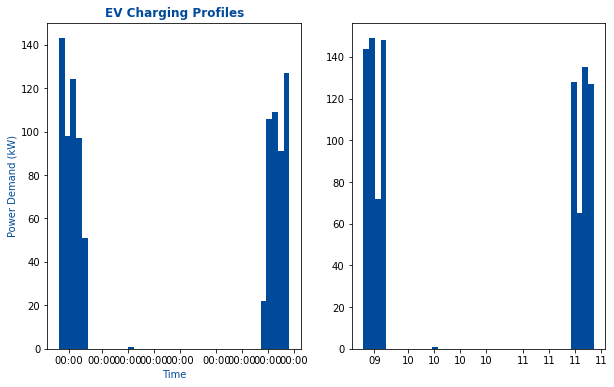

In [27]:
fig, ax = plt.subplots(
    1, 2, figsize=(10, 6), gridspec_kw={'hspace': 0.5})

ax[0].set_title(
    "EV Charging Profiles",
    color=fps_colours[0], fontweight='bold')
ax[0].hist(
    pd.to_datetime(synth_routes['departure_time']),
    bins=40,
    color=fps_colours[0]
    )

ax[1].hist(
    pd.to_datetime(synth_routes['date']),
    bins=40,
    color=fps_colours[0]
    )

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax[0].set_ylabel('Power Demand (kW)', color=fps_colours[0])
ax[0].set_xlabel('Time', color=fps_colours[0])
# ax.set_xlim(left=date, right=date+dt.timedelta(days=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m'))